# Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import OneHotEncoder
import torch
import random
import torch.nn as nn
import torch.optim as optim
import copy
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

In [2]:
# Choosing the device you want : cpu , gpu or tpu

device_type = input("Please choose the type of device you want to use : ")
if device_type=="cpu":
    device = torch.device("cpu")
elif device_type=="gpu":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
elif device_type=="tpu":
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()

print("\nYou are using ", device)

Please choose the type of device you want to use : gpu

You are using  cuda:0


In [3]:
torch.manual_seed(0)

# Data Loading

## Some parameters

In [4]:
event_classes = ['N','AF','I-AVB','LBBB','RBBB','PAC','PVC','STD','STE']
event_encoder = {event_classes[i]:i for i in range(9)}

In [5]:
event_inv_encoder = {v:k for k,v in event_encoder.items()}

In [6]:
n_records = 200
n_leads = 12

## Initial Test

In [3]:
def fnf(n_class,n_lead):
    
    fname = "./CPSC-2018/CPSC_truncated/arrhythmia_class"+str(n_class+1)+"_channel"+str(n_lead)+".parquet"
    return fname

In [4]:
data = pd.read_parquet(fnf(0,5))

In [9]:
data.head()

,A0711,A0716,A0721,A0727,A0736,A0743,A0753,A0772,A0774,A0785,...,A5667,A5827,A5809,A5984,A5992,A5976,A5986,A5991,A6162,A6154
0,0.02628,0.065276,0.046125,0.120363,0.021875,0.213451,0.018694,-0.003874,-0.066271,-0.038385,...,-0.018267,-0.104376,-0.034085,-0.045914,-0.059326,-0.11063,-0.014385,-0.018845,0.027928,0.060156
1,0.02428,0.068276,0.063363,0.128363,0.026052,0.268246,0.018694,-0.010874,-0.101574,-0.047745,...,-0.018267,-0.104376,-0.048243,-0.053914,-0.058326,-0.10863,-0.014385,-0.020845,0.025928,0.065156
2,0.02028,0.065276,0.056220,0.137363,0.020846,0.206690,0.016694,-0.019874,-0.093153,-0.024753,...,-0.018267,-0.104376,-0.044119,-0.054914,-0.058326,-0.10763,-0.011385,-0.021845,0.024928,0.069156
3,0.01728,0.059276,0.054412,0.143363,0.020957,0.219538,0.018694,-0.027874,-0.099267,-0.027414,...,-0.018267,-0.104376,-0.041870,-0.056914,-0.058326,-0.10763,-0.011385,-0.024845,0.021928,0.074156
4,0.01428,0.050276,0.045130,0.147363,0.023766,0.183605,0.016694,-0.031874,-0.100874,-0.040232,...,-0.017267,-0.104376,-0.030921,-0.056914,-0.058326,-0.10763,-0.011385,-0.026845,0.019928,0.078156


In [6]:
data.loc[1].shape

(918,)

In [11]:
data.shape

(2800, 918)

In [12]:
l = data.iloc[:,0]

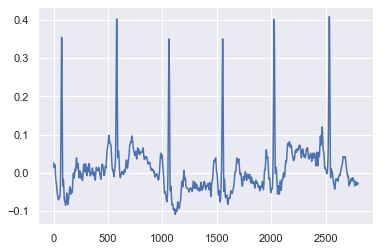

In [13]:
plt.plot(l)
plt.show()

## Data Ingestion

In [14]:
chunk_matrix = []

for i in range(9):
    for j in range(12):
        data = pd.read_parquet(fnf(i,j))
        r,nc = data.shape
        
        for k in range(nc):
            chunk_matrix.append([data.iloc[:,k],i])

In [15]:
chunk_matrix = np.array(chunk_matrix)

In [16]:
chunk_matrix.shape

(82524, 2)

# Data Preparation

## Train-Val-Test Split

In [17]:
X_train, X_test_, y_train, y_test_ = train_test_split(chunk_matrix[:,0],chunk_matrix[:,1],test_size=0.2,shuffle=True,
                                                      stratify=chunk_matrix[:,1],random_state=1)
X_test,X_val,y_test,y_val = train_test_split(X_test_,y_test_,test_size=0.5,shuffle=True,stratify=y_test_,random_state=1)

In [18]:
X_train = np.array(list(X_train))
y_train = np.array(list(y_train))
X_val = np.array(list(X_val))
y_val = np.array(list(y_val))
X_test = np.array(list(X_test))
y_test = np.array(list(y_test))

print(" The shape of X_train is ",X_train.shape)
print(" The shape of y_train is ",y_train.shape)
print(" The shape of X_val is ",X_val.shape)
print(" The shape of y_val is ",y_val.shape)
print(" The shape of X_test is ",X_test.shape)
print(" The shape of y_test is ",y_test.shape)

 The shape of X_train is  (66019, 2800)
 The shape of y_train is  (66019,)
 The shape of X_val is  (8253, 2800)
 The shape of y_val is  (8253,)
 The shape of X_test is  (8252, 2800)
 The shape of y_test is  (8252,)


## Batching

In [19]:
batch_size = 617
n_batches = X_train.shape[0]/batch_size

train_dict = {}
train_dict['batches'] = {}
val_dict = {}
test_dict = {}

train_dict['X_train'] = X_train
train_dict['y_train'] = y_train
val_dict['X_val'] = X_val
val_dict['y_val'] = y_val
test_dict['X_test'] = X_test
test_dict['y_test'] = y_test

train_dict['batches']['X'] = np.split(X_train,n_batches)
train_dict['batches']['y'] = np.split(y_train,n_batches)

print(train_dict['batches']['X'][0].shape,n_batches)

(617, 2800) 107.0


In [20]:
batch_size_val = 393
n_batches_val = X_val.shape[0]/batch_size_val


val_dict['batches'] = {}

val_dict['batches']['X'] = np.split(X_val,n_batches_val)
val_dict['batches']['y'] = np.split(y_val,n_batches_val)

print(val_dict['batches']['X'][0].shape)

(393, 2800)


In [21]:
batch_size_test = 2063
n_batches_test = X_test.shape[0]/batch_size_test


test_dict['batches'] = {}

test_dict['batches']['X'] = np.split(X_test,n_batches_test)
test_dict['batches']['y'] = np.split(y_test,n_batches_test)

print(test_dict['batches']['X'][0].shape)

(2063, 2800)


# HeartNetEC for Event Classification

In [22]:
class HeartNetEC(nn.Module):

    def __init__(self,length):


        super().__init__()
        self.length = length

        self.descend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=1,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,1,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (1,4,L) --> (1,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.descend_Stage1_i_Stage2 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,4,L) --> (N,4,L/2)

        self.descend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=4,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,4,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.descend_Stage2_i_Stage3 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,8,L/2) --> (N,8,L/4)

        self.descend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=8,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,8,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),#(N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.descend_Stage3_i_Stage4 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,16,L/4) --> (N,16,L/8)

        self.descend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=16,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,16,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.descend_Stage4_i_floor = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,32,L/8) --> (N,32,L/16)

        self.floor = nn.Sequential(

            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,32,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU(),
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,64,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU()
        )

        self.ascend_floor_i_Stage4 = nn.ConvTranspose1d(in_channels=64,out_channels=64,kernel_size=8,stride=2,padding=3) # (N,64,L/16) --> (N,64,L/8)

        self.ascend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=96,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,96,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.ascend_Stage4_i_Stage3 = nn.ConvTranspose1d(in_channels=32,out_channels=32,kernel_size=8,stride=2,padding=3) # (N,32,L/8) --> (N,32,L/4)

        self.ascend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=48,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,48,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.ascend_Stage3_i_Stage2 = nn.ConvTranspose1d(in_channels=16,out_channels=16,kernel_size=8,stride=2,padding=3) # (N,16,L/4) --> (N,16,L/2)

        self.ascend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=24,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,24,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.ascend_Stage2_i_Stage1 = nn.ConvTranspose1d(in_channels=8,out_channels=8,kernel_size=8,stride=2,padding=3) # (N,8,L/2) --> (N,8,L)

        self.ascend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=12,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,12,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,4,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.fe_output = nn.Conv1d(in_channels=4,out_channels=1,kernel_size=1)          # (N,4,L) --> (N,1,L)

        self.cl_stage_1 = nn.Sequential(
            
            nn.Linear(in_features=self.length,out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.final_stage = nn.Linear(in_features=64,out_features=10)


    def forward(self,x):

  
        #Pass through Descend Stage-1

        d_1 = self.descend_Stage1(x)



        # Move to Descend Stage-2

        d_1_i_2 = self.descend_Stage1_i_Stage2(d_1)

 

        # Pass through Descend Stage-2

        d_2 = self.descend_Stage2(d_1_i_2)

  

        # Move to Descend Stage-3

        d_2_i_3 = self.descend_Stage2_i_Stage3(d_2)



        # Pass through Descend Stage-3

        d_3 = self.descend_Stage3(d_2_i_3)



        # Move to Descend Stage-4


        d_3_i_4 = self.descend_Stage3_i_Stage4(d_3)



        # Pass through Descend Stage-4

        d_4 = self.descend_Stage4(d_3_i_4)



        # Move to Floor

        d_4_i_f = self.descend_Stage4_i_floor(d_4)



        # Pass through Floor

        d_f = self.floor(d_4_i_f)



        # Move to Ascend Stage-4

        a_f_i_4 = self.ascend_floor_i_Stage4(d_f)


        # Prepare for Ascend Stage-4



        a_p_4 = torch.cat((d_4,a_f_i_4),dim=1)


        # Pass through Ascend Stage-4


        a_4 = self.ascend_Stage4(a_p_4)


        # Move to Ascend Stage-3


        a_4_i_3 = self.ascend_Stage4_i_Stage3(a_4)


        # Prepare for Ascend Stage-3


        a_p_3 = torch.cat((d_3,a_4_i_3),dim=1)


        # Pass through Ascend Stage-3


        a_3 = self.ascend_Stage3(a_p_3)


        # Move to Ascend Stage-2

        a_3_i_2 = self.ascend_Stage3_i_Stage2(a_3)


        # Prepare for Ascend Stage-2

        a_p_2 = torch.cat((d_2,a_3_i_2),dim=1)


        # Pass through Stage-2

        a_2 = self.ascend_Stage2(a_p_2)


        # Move to Ascend Stage-1

        a_2_i_1 = self.ascend_Stage2_i_Stage1(a_2)



        # Prepare for Ascend Stage-1

        a_p_1 = torch.cat((d_1,a_2_i_1),dim=1)


        # Pass through Ascend Stage-1


        a_1 = self.ascend_Stage1(a_p_1)


        # Pass through Final Stage of Feature Extractor


        fe_output = self.fe_output(a_1)

        # Pass through FF Stage - 1

        cl_out_1 = self.cl_stage_1(fe_output.squeeze())

        # Pass through the Final Classifier Stage

        final_output = self.final_stage(cl_out_1)


        return final_output

In [23]:
tst = HeartNetEC(2800)
print(tst)

HeartNetEC(
  (descend_Stage1): Sequential(
    (0): Conv1d(1, 4, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(4, 4, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (descend_Stage1_i_Stage2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (descend_Stage2): Sequential(
    (0): Conv1d(4, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(8, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (descend_Stage2_i_Stage3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (descend_Stage3): Sequ

# Evaluator

## Helper Functions

In [27]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories,
                annot_kws={"size":17,"weight": "bold"})

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    plt.show()

In [25]:
def evaluation(model,config,data,trueLabels,mode,name):

    """ Main Evaluator Function """

    predictedLabels = []

    for data_batch in data:

        data_batch = torch.FloatTensor(data_batch.reshape(config[name],1,-1)).to(device)

        with torch.no_grad():
            temp_predictions = model(data_batch)

    
        del data_batch
        torch.cuda.empty_cache()
        
        predictedLabels = np.append(predictedLabels,list(np.argmax(np.array(temp_predictions.cpu()),axis=1)))




    conf_mat = confusion_matrix(trueLabels,predictedLabels)

    num_TP = {}
    num_FP = {}
    num_FN = {}
    num_TN = {}

    num_TP['all'] = 0
    num_FP['all'] = 0
    num_FN['all'] = 0


    for beat_type in config['beat_classes']:

        num_TP[beat_type] = float(conf_mat[config['beat_transform'][beat_type],config['beat_transform'][beat_type]])
        num_FP[beat_type] = np.sum(conf_mat[:,config['beat_transform'][beat_type]]) - num_TP[beat_type]
        num_FN[beat_type] = np.sum(conf_mat[config['beat_transform'][beat_type],:]) - num_TP[beat_type]
        num_TN[beat_type] = np.sum(conf_mat) - num_TP[beat_type] - num_FP[beat_type] - num_FN[beat_type]

        num_TP['all'] += num_TP[beat_type]
        num_FP['all'] += num_FP[beat_type]
        num_FN['all'] += num_FN[beat_type]

    precision_full = (num_TP['all']/(num_TP['all']+num_FP['all']))
    sensitivity_full = (num_TP['all']/(num_TP['all']+num_FN['all']))
    f1_full = (2*precision_full*sensitivity_full)/(precision_full+sensitivity_full)
    accuracy_full = (num_TP['all'])/np.sum(conf_mat)

    if mode == "Validation":

        return {"accuracy":accuracy_full,
                "precision":precision_full,
                "sensitivity":sensitivity_full,
                "F1":f1_full
               }

    if mode == "Evaluation":

        metrics = classification_report(trueLabels,predictedLabels,target_names=config['beat_classes'],output_dict=True)

        for beat_type in config['beat_classes']:

            metrics[beat_type]["Accuracy"] = (num_TP[beat_type]+num_TN[beat_type])/np.sum(conf_mat)

        metrics['all'] = {}

        metrics['all']['precision'] = precision_full 
        metrics['all']['recall'] = sensitivity_full
        metrics['all']['f1-score'] = f1_full
        metrics['all']['Accuracy'] = accuracy_full

        return metrics,conf_mat

# Core Training Function

In [26]:
config = {}

config['batch_size'] = batch_size
config['n_batches'] = n_batches
config['batch_size_val'] = batch_size_val
config['n_batches_val'] = n_batches_val
config['batch_size_test'] = batch_size_test
config['n_batches_test'] = n_batches_test
config['feature_length'] = 2800
config['lr'] = 0.001
config['device'] = device
config['device_type'] = device_type
config['beat_classes'] = event_classes
config['beat_transform'] = event_encoder
config['beat_inv_transform'] = event_inv_encoder

## Core Training Function

In [51]:
def ultimate_trainer(trainData,valData,testData,epochs,config,verbose=False,visualize=True,download_model=False):

    """ Trains HeartNet Models for Beat Classification """

    print("------------------------------------------------------------------------------------------")
    print("\t\t\t TRAINING EXPERIMENT")
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING CONFIGURATION")
    print("------------------------------------------------------------------------------------------")

    print("--> The HeartNet Model is being trained for Beat Classification")
    print("--> You are using a  " + config['device_type'])
    print("--> The epochs specified for training : ",epochs)
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING")
    print("------------------------------------------------------------------------------------------")


    # Model Instantiation and Model Parameters

    model = HeartNetEC(config['feature_length'])

    model = model.to(config['device'])

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr=config['lr'])

    # Some variables for Training and Validation Visualization
    sensitivity_plot_val = []
    precision_plot_val = []
    F1_plot_val = []
    accuracy_plot_val = []

    loss_train_plot = []
    sensitivity_plot_train = []
    precision_plot_train = []
    F1_plot_train = []
    accuracy_plot_train = []

    # Some variables for Checkpointing

    min_train_loss = 1000
    max_val_F1 = 0
    max_train_F1 = 0

    # Training

    for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):

        # Now go through each batch

        for train_batch,label_batch in zip(train_dict['batches']['X'],train_dict['batches']['y']):

            # Convert to Tensors

            train_batch = torch.FloatTensor(train_batch.reshape(batch_size,1,-1))

            label_batch = torch.LongTensor(label_batch)

            # Move to Specified Device

            train_batch,label_batch = train_batch.to(device),label_batch.to(device)

            # Initialize gradients to zero
            
            optimizer.zero_grad()

            # Forward Pass

            prediction = model(train_batch)

            # Compute the Loss

            loss = loss_fn(prediction,label_batch)

            # Backpropagation

            loss.backward()

            # Take a Step and update the parameters

            optimizer.step()

            # Now Checkpointing the model loss

            if min_train_loss > loss.item() :

                min_train_loss = loss.item()
                #best_train_model = copy.deepcopy(model.state_dict())
                print("+-> Min Training Loss : "+str(min_train_loss))

            # Freeing the GPU

            del train_batch,label_batch,prediction
            torch.cuda.empty_cache()

        # Some Bookkeeping for Training

        loss_train_plot.append(loss.item())

        # Put the Model in Evaluation Mode

        model.eval()

        # Evaluating Train Data

        train_metrics,val_metrics = evaluation(model=model,config=config,data=trainData['batches']['X'],trueLabels=trainData['y_train'],mode='Validation',name='batch_size'),evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Validation',name='batch_size_val')


        # Bookkeeping

        sensitivity_plot_train.append(train_metrics['sensitivity'])
        precision_plot_train.append(train_metrics['precision'])
        F1_plot_train.append(train_metrics['F1'])
        accuracy_plot_train.append(train_metrics['accuracy'])

        sensitivity_plot_val.append(val_metrics['sensitivity'])
        precision_plot_val.append(val_metrics['precision'])
        F1_plot_val.append(val_metrics['F1'])
        accuracy_plot_val.append(val_metrics['accuracy'])

        # Checkpointing the Best Validation Model

        if max_val_F1 < val_metrics['F1']:

            max_val_F1 = val_metrics['F1']

            best_val_model = copy.deepcopy(model.state_dict())

            print("+-> Maximum Validation F1 (in %) obtained is ",max_val_F1)

        # Put the Model back in Training Mode

        model.train()

    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING COMPLETE")
    print("------------------------------------------------------------------------------------------")
    plt.plot(loss_train_plot,'r-')
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss : Cross Entropy Loss")
    plt.title("LOSS PLOT")
    plt.show()

    if visualize :
        print("------------------------------------------------------------------------------------------")
        print("\t VISUALIZATION ")
        print("------------------------------------------------------------------------------------------")
        # Visualization

        plt.plot(accuracy_plot_train,'r-',label='Train Data')
        plt.plot(accuracy_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()


        plt.plot(sensitivity_plot_train,'r-',label='Train Data')
        plt.plot(sensitivity_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Sensitivity")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(precision_plot_train,'r-',label='Train Data')
        plt.plot(precision_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(F1_plot_train,'r-',label='Train Data')
        plt.plot(F1_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("F1 Score")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        print("------------------------------------------------------------------------------------------")
        print("\t METRICS FOR BEST VALIDATION MODEL")
        print("------------------------------------------------------------------------------------------")
        print("VALIDATION SET")
        print("------------------------------------------------------------------------------------------")

        model.load_state_dict(best_val_model)

        model.eval()

        best_metrics_val,conf_matrix_val = evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Evaluation',name='batch_size_val')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_val,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_val = pd.DataFrame.from_dict(best_metrics_val)
        df_val = df_val.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_val = df_val.drop(['support'],axis=0)
        display(df_val.T)

        print("------------------------------------------------------------------------------------------")
        print("TEST SET")
        print("------------------------------------------------------------------------------------------")

        best_metrics_test,conf_matrix_test = evaluation(model=model,config=config,data=testData['batches']['X'],trueLabels=testData['y_test'],mode='Evaluation',name='batch_size_test')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_test,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_test = pd.DataFrame.from_dict(best_metrics_test)
        df_test = df_test.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_test = df_test.drop(['support'],axis=0)
        display(df_test.T)

        print("------------------------------------------------------------------------------------------")
        print("\t EVALUATION COMPLETE")
        print("------------------------------------------------------------------------------------------")

    # Now download the model for future use

    if download_model :

        print("DOWNLOADING MODEL ...")

        torch.save(best_val_model,"HRT_NET_MODEL_2")

        print("DOWNLOADING COMPLETE !!!")


    return best_val_model

# Training

## Test Run

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  1
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-46-5639959d227e>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.400383472442627
+-> Min Training Loss : 2.360445022583008
+-> Min Training Loss : 2.3131911754608154
+-> Min Training Loss : 2.2785556316375732
+-> Min Training Loss : 2.2544596195220947
+-> Min Training Loss : 2.2244787216186523
+-> Min Training Loss : 2.1742641925811768
+-> Min Training Loss : 2.1650888919830322
+-> Min Training Loss : 2.1248016357421875
+-> Min Training Loss : 2.1211633682250977
+-> Min Training Loss : 2.103388547897339
+-> Min Training Loss : 2.072017192840576
+-> Min Training Loss : 2.068676233291626
+-> Min Training Loss : 2.0614871978759766
+-> Min Training Loss : 2.021604537963867
+-> Min Training Loss : 2.019327402114868
+-> Min Training Loss : 2.0066051483154297
+-> Min Training Loss : 1.9899823665618896
+-> Min Training Loss : 1.967712640762329
+-> Min Training Loss : 1.9546458721160889
+-> Min Training Loss : 1.9368029832839966
+-> Min Training Loss : 1.9182666540145874
+-> Min Training Loss : 1.8863422870635986
+-> Min Training Lo

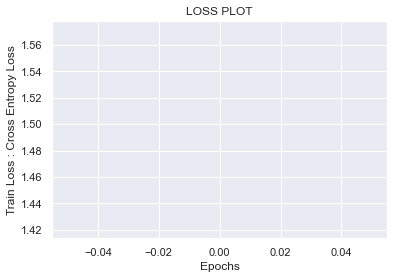

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


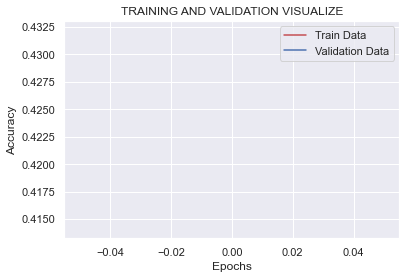

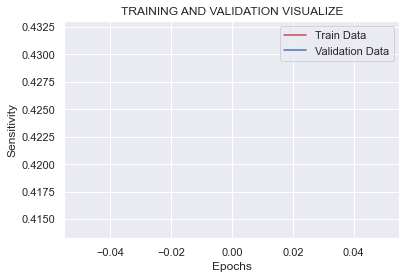

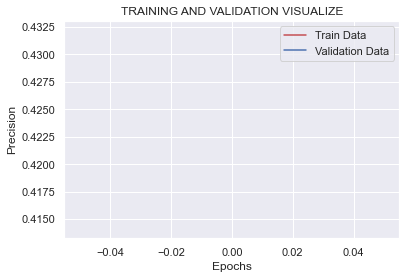

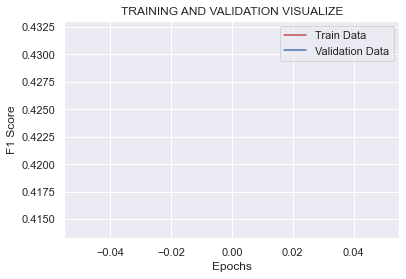

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




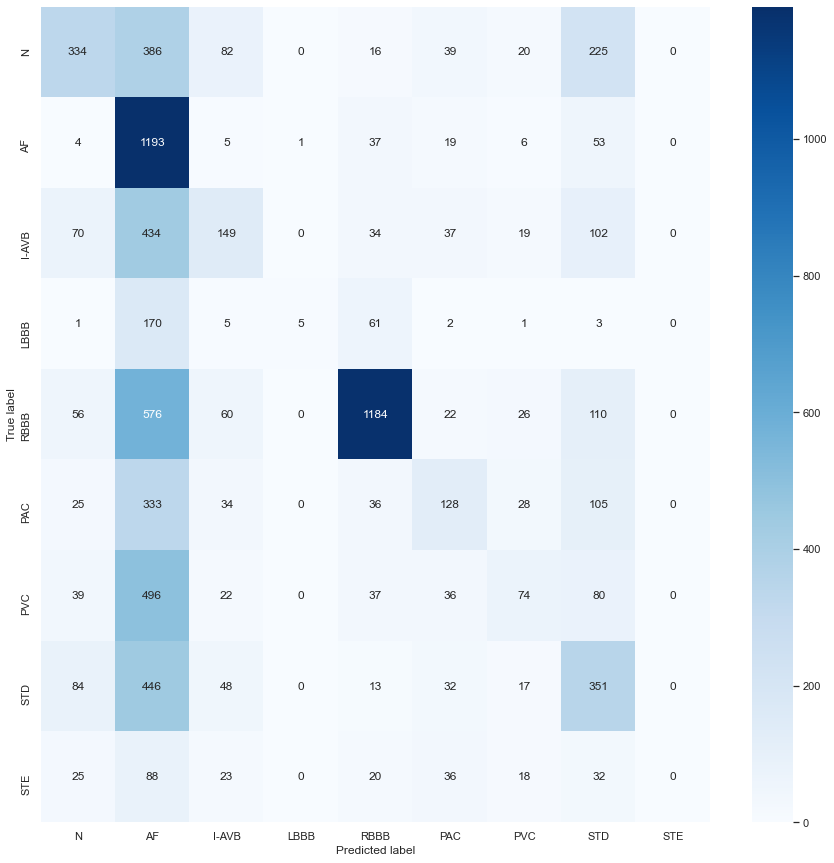



Metrics




,precision,recall,f1-score,Accuracy
N,0.523511,0.303085,0.383908,0.870108
AF,0.289423,0.905159,0.438603,0.629953
I-AVB,0.348131,0.176331,0.234093,0.881861
LBBB,0.833333,0.020161,0.039370,0.970435
RBBB,0.823366,0.582104,0.682028,0.866230
PAC,0.364672,0.185776,0.246154,0.905004
PVC,0.354067,0.094388,0.149043,0.897613
STD,0.330820,0.354188,0.342105,0.836423
STE,0.000000,0.000000,0.000000,0.970677
all,0.414152,0.414152,0.414152,0.414152


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




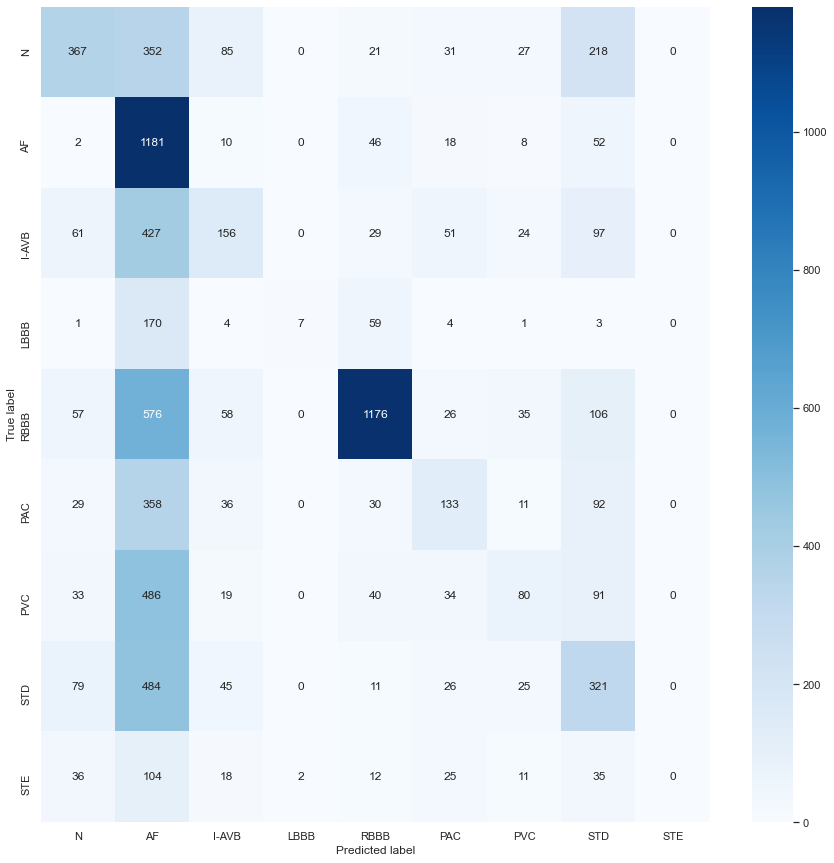



Metrics




,precision,recall,f1-score,Accuracy
N,0.551880,0.333333,0.415629,0.874939
AF,0.285404,0.896735,0.432997,0.625182
I-AVB,0.361949,0.184615,0.244514,0.883180
LBBB,0.777778,0.028112,0.054264,0.970431
RBBB,0.825843,0.578171,0.680162,0.865972
PAC,0.382184,0.193033,0.256509,0.906568
PVC,0.360360,0.102171,0.159204,0.897601
STD,0.316256,0.323915,0.320040,0.834707
STE,0.000000,0.000000,0.000000,0.970553
all,0.414566,0.414566,0.414566,0.414566


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------


In [49]:
test = ultimate_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=1,config=config,verbose=False,visualize=True,download_model=False)

## Experiment-1

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-46-5639959d227e>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.3589813709259033
+-> Min Training Loss : 2.308159828186035
+-> Min Training Loss : 2.294485330581665
+-> Min Training Loss : 2.2638750076293945
+-> Min Training Loss : 2.236968517303467
+-> Min Training Loss : 2.228339195251465
+-> Min Training Loss : 2.2118632793426514
+-> Min Training Loss : 2.2088356018066406
+-> Min Training Loss : 2.206845760345459
+-> Min Training Loss : 2.1758460998535156
+-> Min Training Loss : 2.1710703372955322
+-> Min Training Loss : 2.1620516777038574
+-> Min Training Loss : 2.161848306655884
+-> Min Training Loss : 2.1274325847625732
+-> Min Training Loss : 2.082444667816162
+-> Min Training Loss : 2.0744166374206543
+-> Min Training Loss : 2.0458176136016846
+-> Min Training Loss : 2.0164172649383545
+-> Min Training Loss : 2.008481740951538
+-> Min Training Loss : 1.9901008605957031
+-> Min Training Loss : 1.9825633764266968
+-> Min Training Loss : 1.9451411962509155
+-> Min Training Loss : 1.9247368574142456
+-> Min Training Lo

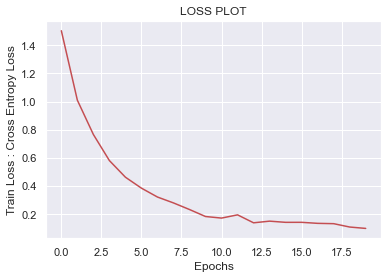

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


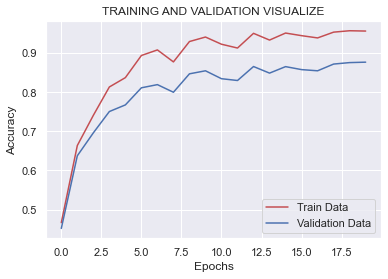

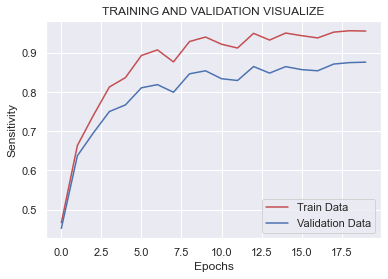

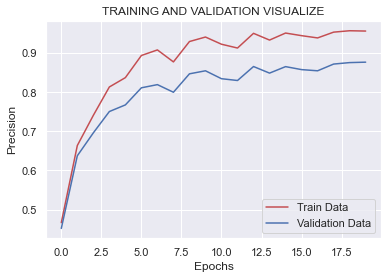

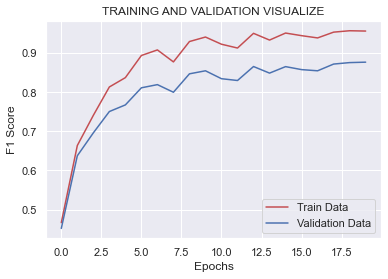

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




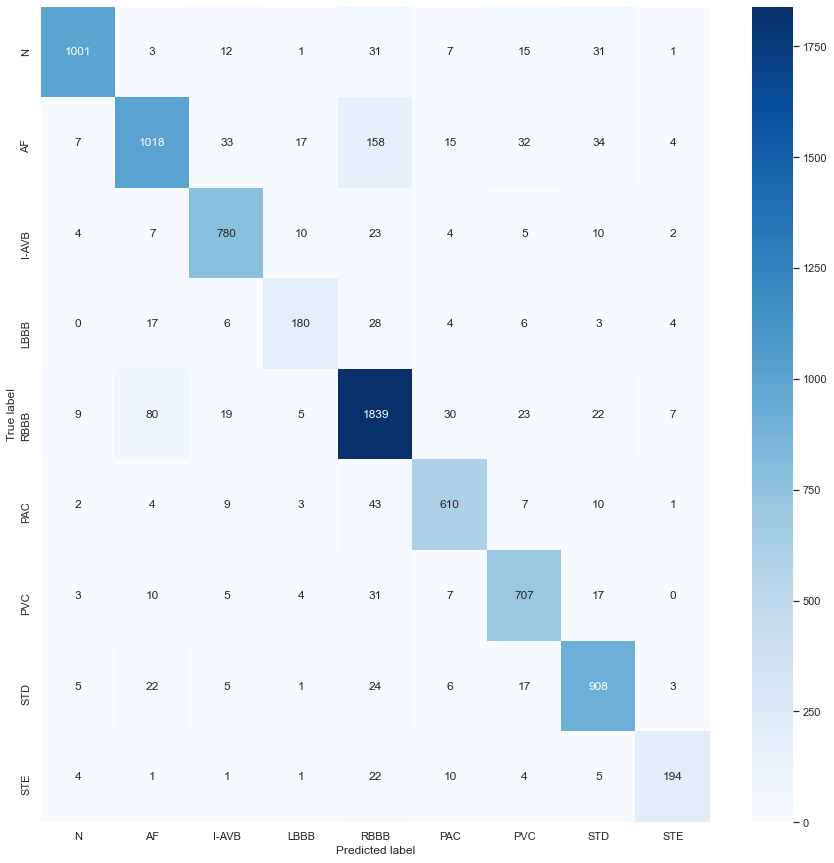



Metrics




,precision,recall,f1-score,Accuracy
N,0.967150,0.908348,0.936827,0.983642
AF,0.876076,0.772382,0.820968,0.946201
I-AVB,0.896552,0.923077,0.909621,0.981219
LBBB,0.810811,0.725806,0.765957,0.986672
RBBB,0.836289,0.904130,0.868887,0.932752
PAC,0.880231,0.885341,0.882779,0.980371
PVC,0.866422,0.901786,0.883750,0.977463
STD,0.873077,0.916246,0.894141,0.973949
STE,0.898148,0.801653,0.847162,0.991518
all,0.876893,0.876893,0.876893,0.876893


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




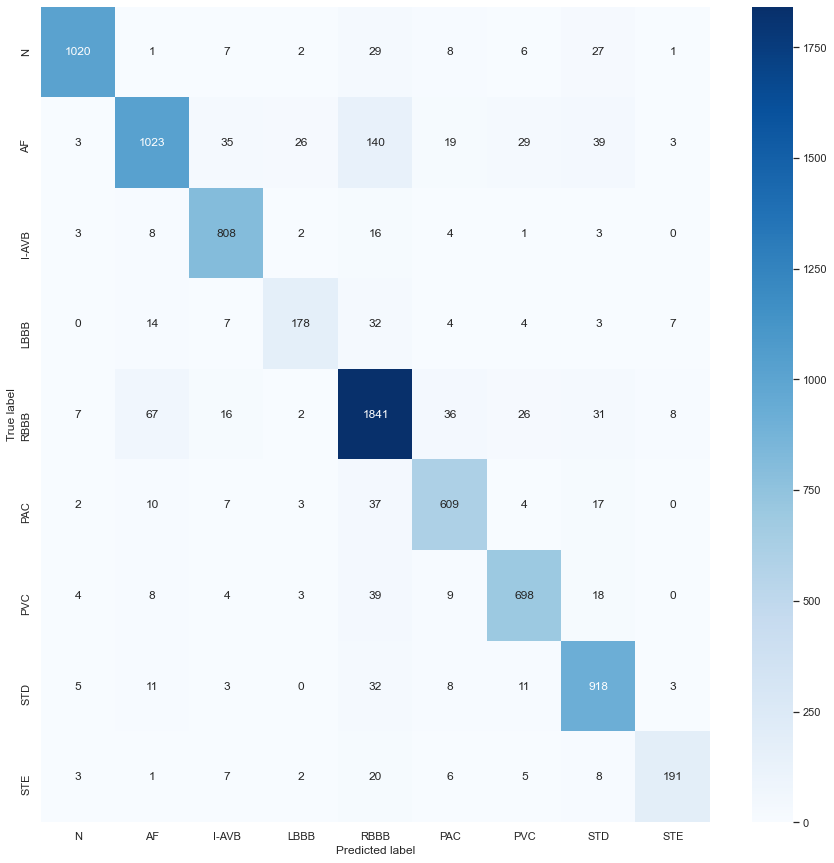



Metrics




,precision,recall,f1-score,Accuracy
N,0.974212,0.926431,0.949721,0.986912
AF,0.895013,0.776765,0.831707,0.949830
I-AVB,0.903803,0.956213,0.929270,0.985095
LBBB,0.816514,0.714859,0.762313,0.986549
RBBB,0.842177,0.905113,0.872512,0.934804
PAC,0.866287,0.883890,0.875000,0.978914
PVC,0.890306,0.891443,0.890874,0.979278
STD,0.862782,0.926337,0.893431,0.973461
STE,0.896714,0.786008,0.837719,0.991032
all,0.882937,0.882937,0.882937,0.882937


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [50]:
best_val_model = ultimate_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=20,config=config,verbose=False,visualize=True,download_model=True)

## Experiment-2

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  50
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-51-ea80e6ab1593>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.426626443862915
+-> Min Training Loss : 2.4024322032928467
+-> Min Training Loss : 2.3390746116638184
+-> Min Training Loss : 2.284620523452759
+-> Min Training Loss : 2.260535717010498
+-> Min Training Loss : 2.2165029048919678
+-> Min Training Loss : 2.208526849746704
+-> Min Training Loss : 2.201577663421631
+-> Min Training Loss : 2.186612844467163
+-> Min Training Loss : 2.1595828533172607
+-> Min Training Loss : 2.1452596187591553
+-> Min Training Loss : 2.131967544555664
+-> Min Training Loss : 2.1289308071136475
+-> Min Training Loss : 2.081792116165161
+-> Min Training Loss : 2.0803475379943848
+-> Min Training Loss : 2.073277473449707
+-> Min Training Loss : 2.0590033531188965
+-> Min Training Loss : 2.048227548599243
+-> Min Training Loss : 2.0097551345825195
+-> Min Training Loss : 1.9761929512023926
+-> Min Training Loss : 1.9654406309127808
+-> Min Training Loss : 1.9291988611221313
+-> Min Training Loss : 1.883400321006775
+-> Min Training Loss 

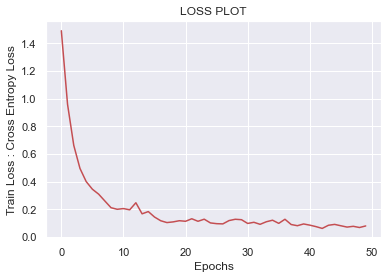

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


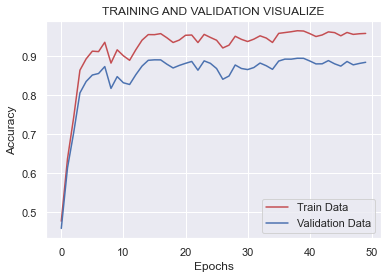

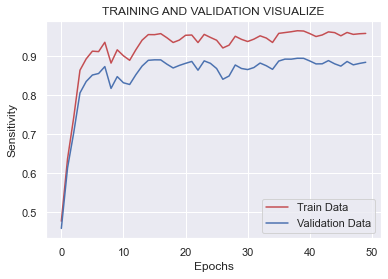

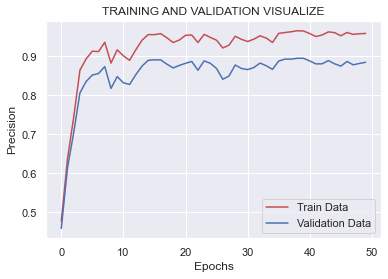

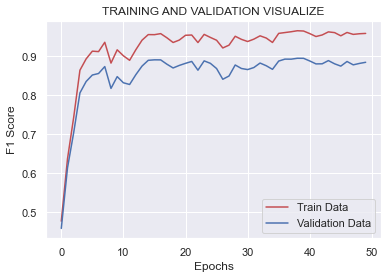

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




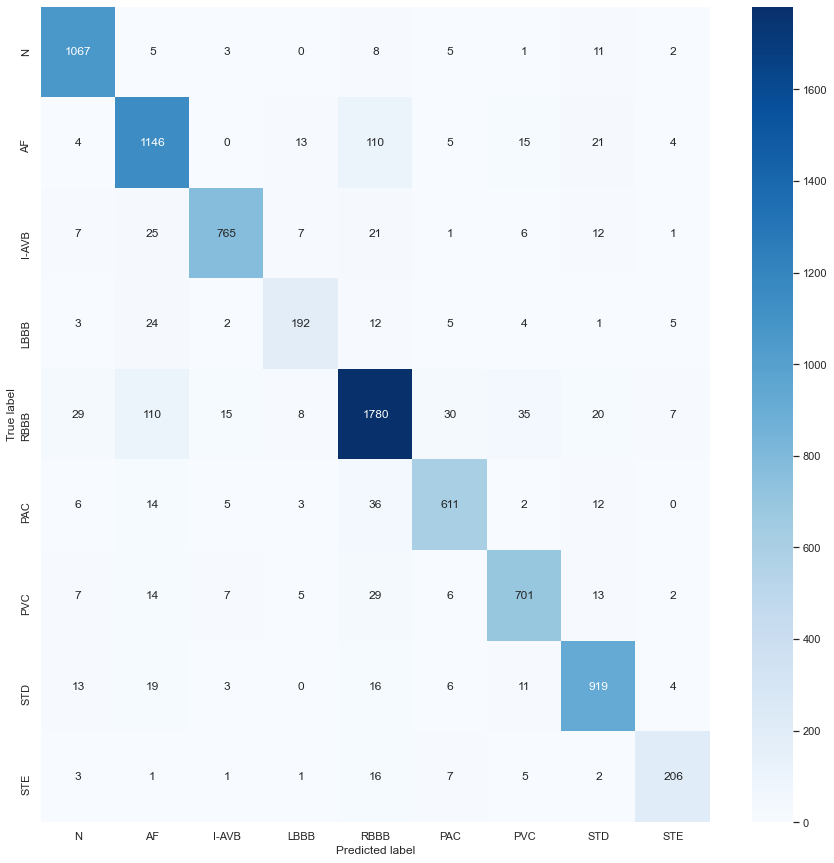



Metrics




,precision,recall,f1-score,Accuracy
N,0.936787,0.968240,0.952253,0.987035
AF,0.843888,0.869499,0.856502,0.953471
I-AVB,0.955056,0.905325,0.929526,0.985945
LBBB,0.838428,0.774194,0.805031,0.988731
RBBB,0.877712,0.875123,0.876416,0.939174
PAC,0.903846,0.886792,0.895238,0.982673
PVC,0.898718,0.894133,0.896419,0.980371
STD,0.909001,0.927346,0.918082,0.980128
STE,0.891775,0.851240,0.871036,0.992609
all,0.895068,0.895068,0.895068,0.895068


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




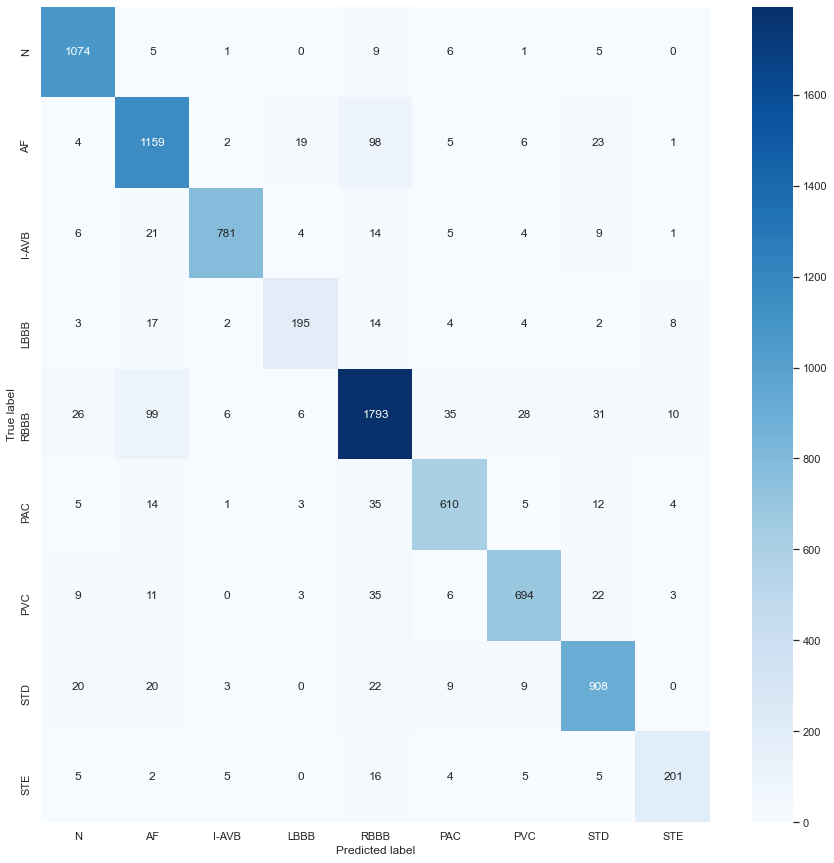



Metrics




,precision,recall,f1-score,Accuracy
N,0.932292,0.975477,0.953395,0.987276
AF,0.859792,0.880030,0.869794,0.957950
I-AVB,0.975031,0.924260,0.948967,0.989821
LBBB,0.847826,0.783133,0.814196,0.989215
RBBB,0.880648,0.881514,0.881081,0.941348
PAC,0.891813,0.885341,0.888565,0.981459
PVC,0.917989,0.886335,0.901884,0.981701
STD,0.892822,0.916246,0.904382,0.976733
STE,0.881579,0.827160,0.853503,0.991638
all,0.898570,0.898570,0.898570,0.898570


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [52]:
best_val_model = ultimate_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=50,config=config,verbose=False,visualize=True,download_model=True)